In [1]:
!pip install flask
!pip install pyserial
!pip install opencv-python
!pip install nbimporter
!pip install torch torchaudio torchvision
!jupyter nbconvert --to script text_processing.ipynb
!jupyter nbconvert --to script camera_operation.ipynb
!jupyter nbconvert --to script braille_translate.ipynb

[NbConvertApp] Converting notebook text_processing.ipynb to script
[NbConvertApp] Writing 3739 bytes to text_processing.py
[NbConvertApp] Converting notebook camera_operation.ipynb to script
[NbConvertApp] Writing 675 bytes to camera_operation.py
[NbConvertApp] Converting notebook braille_translate.ipynb to script
[NbConvertApp] Writing 6609 bytes to braille_translate.py


In [4]:
from flask import Flask, render_template, Response, send_file
import serial
import time
import os
import cv2
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import io
import threading
import subprocess
import nbimporter
from camera_operation import taking_picture
from text_processing import text_correction, text_detection
from braille_translate import text_to_braille

app = Flask(__name__)

# 연결할 시리얼 포트와 baudrate 설정
ser = serial.Serial('COM7', 9600)

# 변수 선언 및 초기화
camera = cv2.VideoCapture(2)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
recognized_texts_global = []
current_text_index = 0
braille_texts = []

def read_from_port(ser):
    # 인식된 텍스트를 저장할 전역 변수
    global recognized_texts_global
    global current_text_index
    global braille_texts
    
    while True:
        reading = ser.readline().decode().strip()  # 끝의 줄바꿈 제거
        print("===============  Received from Arduino -> ", reading, "  ===============")
        if reading == "Take Picture":
            # 이미지 촬영
            print("< 1 - 이미지 촬영 >")
            img_path = taking_picture(camera)

            # 널값인지 검사
            if img_path is None:
                continue

            # 텍스트 인식
            print("< 2 - 텍스트 인식 >")
            recognized_texts = text_detection(img_path)
                
            # 인식된 텍스트 처리
            words_list = [word for text in recognized_texts for word in text.split()]
            try:
                corrected_texts = text_correction(words_list)
            except ValueError as e:
                print(f"예외 발생: {e}")
                continue
            
            filtered_texts = [text for text in corrected_texts if text.strip()]
            #filtered_texts = [text for text in words_list if text.strip()]
            print("인식된 텍스트 >>> ", filtered_texts)
            recognized_texts_global = filtered_texts  # 새로운 텍스트로 업데이트
            current_text_index = 0  # 새로운 텍스트 리스트로 업데이트되면 인덱스 초기화

            
            # 텍스트를 점자로 변환하여 저장
            print("< 3 - 텍스트 점자로 변환 >")
            braille_texts = text_to_braille(filtered_texts)
            print("점자 텍스트 >>> ", braille_texts)
            
        elif reading == "Next":
            next_text()
            
        elif reading == "Previous":
            previous_text()
            
def next_text():
    global current_text_index
    
    if len(recognized_texts_global) == 0:
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index < len(recognized_texts_global) - 1:
        send_text_to_arduino(recognized_texts_global[current_text_index], braille_texts[current_text_index])
        current_text_index += 1
    else:
        print("리스트의 끝점입니다.")

def previous_text():
    global current_text_index
    
    if len(recognized_texts_global) == 0:
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index > 0:
        send_text_to_arduino(recognized_texts_global[current_text_index], braille_texts[current_text_index])
        current_text_index -= 1
        
    else:
        print("리스트의 시작점입니다.")

def send_text_to_arduino(text, braille):
    print("단어:", text)
    print("점자:", braille)
    ser.write((braille + "\n").encode())

# 프로그램 종료 시 자원 해제
def release_resources():
    camera.release()
    ser.close()

def generate_frames():
    while True:
        success, frame = camera.read()  # 카메라로부터 프레임 읽기
        if not success:
            break
        else:
            ret, buffer = cv2.imencode('.jpg', frame)
            frame = buffer.tobytes()
            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')

@app.route('/')
def index():
    return render_template('braille.html')

@app.route('/video')
def video():
    return Response(generate_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

thread = threading.Thread(target=read_from_port, args=(ser,))
thread.start()

if __name__ == '__main__':
    app.run(debug=False, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.18:5000
Press CTRL+C to quit


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.18:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Jun/2024 05:58:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.3572085710966937 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.8745640837255848 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.8266011881879294 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.9352309569149064 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.4162310764539363 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.7774141146247402 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.974641004593241 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.10329117112242936 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:45] "GET /video?rand=0.6270348147781106 HTTP/1.1" 200 -
127.0

===============  Received from Arduino ->  Take Picture   ===============
< 1 - 이미지 촬영 >
1-1 이미지 촬영 진행 중입니다.
1-2 이미지 촬영이 완료되었습니다.
이미지 경로 : C:\Users\peter\capstone\camera\20240602-055849.jpg

< 2 - 텍스트 인식 >
2-1 이미지 내 텍스트 인식을 진행 중입니다.


127.0.0.1 - - [02/Jun/2024 05:58:49] "GET /video?rand=0.31526742015643405 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:58:49] "GET /arduino_received_message HTTP/1.1" 200 -
[2024-06-02 05:58:49,463] ERROR in app: Exception on /labelled_image [GET]
Traceback (most recent call last):
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\site-packages\flask\app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_fun

2-2 이미지 내 텍스트 인식을 완료했습니다.


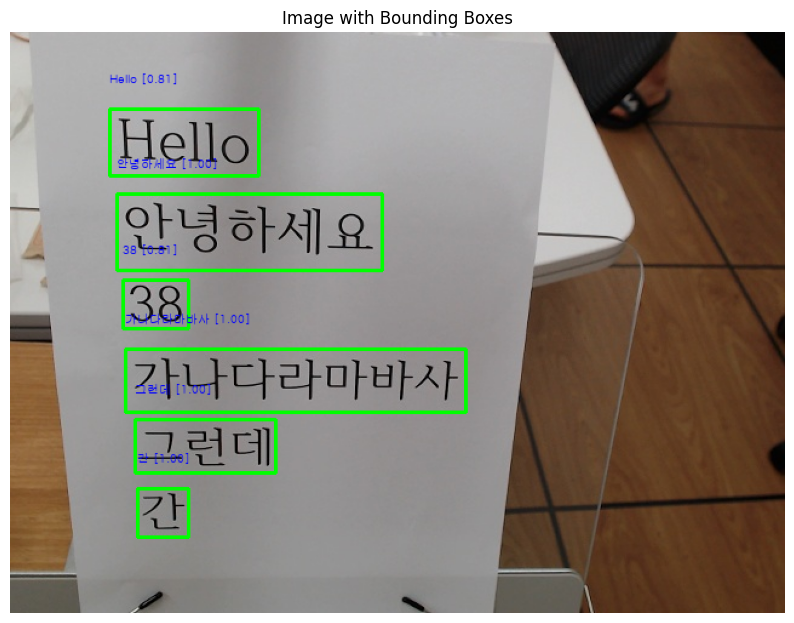

2-3 이미지 내 텍스트 라벨링 및 저장을 완료했습니다.
2-4 텍스트 철자 및 문법 교정을 진행 중입니다. 
한글 텍스트는 현재 지원하지 않습니다.


127.0.0.1 - - [02/Jun/2024 05:59:02] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:02] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:02] "GET /video?rand=0.02806102285205969 HTTP/1.1" 200 -


한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
한글 텍스트는 현재 지원하지 않습니다.
2-5 철자 및 문법 교정을 완료했습니다.
인식된 텍스트 >>>  ['Hello', '안녕하세요', '38', '가나다라마바사', '그런데', '간']
< 3 - 텍스트 점자로 변환 >
텍스트를 점자로 변환 중입니다...
점자 변환이 완료됐습니다.
점자 텍스트 >>>  ['3603421270705226', '4322114724035435', '371142', '4511210243120470', '1054', '4522']


127.0.0.1 - - [02/Jun/2024 05:59:02] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:02] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:02] "GET /video?rand=0.04715832202943315 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:03] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:03] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:03] "GET /video?rand=0.6340933635044923 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:04] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:04] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:04] "GET /labelled_image HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:04] "GET /video?rand=0.06167312037899997 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:05] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:05] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun

===============  Received from Arduino ->  Next   ===============
단어: Hello
점자: 3603421270705226


127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=0.5628545322555083 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=0.896170854815233 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=0.7441780324989011 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=0.9051829261356601 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=0.13967734341288973 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /labelled_image HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=0.6240704486708852 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=0.6012647328585825 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=0.09416235899776337 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:19] "GET /video?rand=

===============  Received from Arduino ->  Next   ===============
단어: 안녕하세요
점자: 4322114724035435


127.0.0.1 - - [02/Jun/2024 05:59:30] "GET /video?rand=0.17135761830791618 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:30] "GET /video?rand=0.5076582407323256 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:30] "GET /video?rand=0.6740438969091331 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:31] "GET /video?rand=0.48450020768340907 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:31] "GET /video?rand=0.9480229775505982 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:31] "GET /video?rand=0.05444687758047806 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:31] "GET /video?rand=0.03960668546334767 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:31] "GET /video?rand=0.24176409571340285 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:31] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:31] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:31] "GET /video?rand=0.43972352488761834 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:3

===============  Received from Arduino ->  Next   ===============
단어: 38
점자: 371142


127.0.0.1 - - [02/Jun/2024 05:59:33] "GET /video?rand=0.28574355037884014 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:33] "GET /video?rand=0.9836346612901985 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:33] "GET /video?rand=0.17341180078420915 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:33] "GET /video?rand=0.6999416819394852 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:34] "GET /video?rand=0.5033648161172284 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:34] "GET /video?rand=0.7226217440588714 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:34] "GET /video?rand=0.6738326049552243 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:34] "GET /video?rand=0.8758097832486396 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:34] "GET /video?rand=0.5699494915848582 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:34] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:34] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:34] "

===============  Received from Arduino ->  Next   ===============
단어: 가나다라마바사
점자: 4511210243120470


127.0.0.1 - - [02/Jun/2024 05:59:55] "GET /video?rand=0.9888366431422075 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:55] "GET /video?rand=0.05072346120510751 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:55] "GET /video?rand=0.639749326799061 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] "GET /video?rand=0.2867516195556561 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] "GET /video?rand=0.01816984061629645 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] "GET /video?rand=0.6888788927248122 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] "GET /video?rand=0.17627666335257586 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] "GET /video?rand=0.3912998406856123 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] "GET /video?rand=0.08133856853044441 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 05:59:56] 

===============  Received from Arduino ->  Next   ===============
단어: 그런데
점자: 1054


127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /video?rand=0.9755524234114745 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /video?rand=0.10187383798799088 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /video?rand=0.8625232276527401 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /video?rand=0.07844541352581214 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /video?rand=0.7756706542724292 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /video?rand=0.28589720824359666 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:22] "GET /video?rand=0.24302157088137855 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.18006555415714876 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.3487880571707034 HTTP/1.1" 200 -


===============  Received from Arduino ->  Next   ===============
리스트의 끝점입니다.


127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.5731832859727484 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.876315494825326 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.05628877715727865 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.08099007351383314 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.2090521079213532 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.6486606035345814 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.7278199390726663 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:23] "GET /video?rand=0.9880000207074928 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:24] "GET /video?rand=0.3553954494507876 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:24] "G

===============  Received from Arduino ->  Previous   ===============
단어: 간
점자: 4522


127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /video?rand=0.17504383652130961 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /video?rand=0.7153784224297393 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /video?rand=0.34322593183842054 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /video?rand=0.009625182734612103 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /video?rand=0.7454018497262591 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /video?rand=0.6397177127086615 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:25] "GET /video?rand=0.899627325757782 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:26] "GET /video?rand=0.6214257304610591 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:26] "GET /video?rand=0.0687182437677627 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:26] 

===============  Received from Arduino ->  Previous   ===============
단어: 그런데
점자: 1054


127.0.0.1 - - [02/Jun/2024 06:00:27] "GET /video?rand=0.9084997986351242 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:27] "GET /video?rand=0.7120728980647983 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:27] "GET /video?rand=0.10769692309838952 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.11243578096161722 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.752781841869121 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.04466186047695886 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.8747127150235476 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.7141052942245749 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.5183029088911832 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "

===============  Received from Arduino ->  Previous   ===============
단어: 가나다라마바사
점자: 4511210243120470


127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.9432951474247333 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.18582863519287618 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:28] "GET /video?rand=0.5414412414869965 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /video?rand=0.755278038006792 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /video?rand=0.43494262015566654 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /video?rand=0.3694856095085901 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /video?rand=0.9834278570761568 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /video?rand=0.3662971223575444 HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /labelled_image HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2024 06:00:29] "GET /video?rand=

In [ ]:
from flask import Flask, render_template, Response, request
import serial
import time
import os
import cv2
import threading
import subprocess
import nbimporter
from camera_operation import taking_picture
from text_processing import text_correction, text_detection
from braille_translate import text_to_braille

app = Flask(__name__)

ser = serial.Serial('COM7', 9600)

camera = cv2.VideoCapture(1)
recognized_texts_global = []
current_text_index = 0
braille_texts = []
labeled_img_path = None
last_arduino_message = ""  # Arduino로부터 받은 마지막 메시지를 저장하는 변수

def read_from_port(ser):
    global recognized_texts_global, current_text_index, braille_texts, labeled_img_path, last_arduino_message
    
    while True:
        reading = ser.readline().decode().strip()
        last_arduino_message = reading  # 마지막 Arduino 메시지 업데이트
        print("===============  Received from Arduino -> ", reading, "  ===============")
        if reading == "Take Picture":
            # 이미지 촬영
            print("< 1 - 이미지 촬영 >")
            img_path = taking_picture(camera)

            # 널값인지 검사
            if img_path is None:
                continue

            # 텍스트 인식
            print("< 2 - 텍스트 인식 >")
            recognized_texts, labeled_img_path = text_detection(img_path)
                
            # 인식된 텍스트 처리
            words_list = [word for text in recognized_texts for word in text.split()]
            try:
                corrected_texts = text_correction(words_list)
            except ValueError as e:
                print(f"예외 발생: {e}")
                continue
            
            filtered_texts = [text for text in corrected_texts if text.strip()]
            #filtered_texts = [text for text in words_list if text.strip()]
            print("인식된 텍스트 >>> ", filtered_texts)
            recognized_texts_global = filtered_texts  # 새로운 텍스트로 업데이트
            current_text_index = 0  # 새로운 텍스트 리스트로 업데이트되면 인덱스 초기화

            
            # 텍스트를 점자로 변환하여 저장
            print("< 3 - 텍스트 점자로 변환 >")
            braille_texts = text_to_braille(filtered_texts)
            print("점자 텍스트 >>> ", braille_texts)

        elif reading == "Next":
            next_text()
            
        elif reading == "Previous":
            previous_text()

def next_text():
    global current_text_index
    
    if len(recognized_texts_global) == 0:
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index < len(recognized_texts_global) - 1:
        send_text_to_arduino(recognized_texts_global[current_text_index], braille_texts[current_text_index])
        current_text_index += 1
    else:
        print("리스트의 끝점입니다.")

def previous_text():
    global current_text_index
    
    if len(recognized_texts_global) == 0:
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index > 0:
        send_text_to_arduino(recognized_texts_global[current_text_index], braille_texts[current_text_index])
        current_text_index -= 1
        
    else:
        print("리스트의 시작점입니다.")

def send_text_to_arduino(text, braille):
    print("단어:", text)
    print("점자:", braille)
    ser.write((braille + "\n").encode())

def generate_frames():
    while True:
        success, frame = camera.read()  # 카메라로부터 프레임 읽기
        if not success:
            break
        else:
            ret, buffer = cv2.imencode('.jpg', frame)
            frame = buffer.tobytes()
            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
@app.route('/')
def index():
    return render_template('test6.html')

@app.route('/video')
def video():
    return Response(generate_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/labelled_image')
def labelled_image():
    img = cv2.imread(labeled_img_path)
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_io = io.BytesIO()
    img_pil.save(img_io, 'JPEG', quality=70)
    img_io.seek(0)
    return Response(img_io.getvalue(), mimetype='image/jpeg')

@app.route('/arduino_received_message')
def arduino_received_message():
    # Arduino로부터 받은 마지막 메시지를 반환합니다.
    return {"message": last_arduino_message}

@app.route('/send_to_arduino')
def send_to_arduino():
    # Arduino로 보낸 문자열 반환
    return {"message": recognized_texts_global[current_text_index]}

if __name__ == '__main__':
    thread = threading.Thread(target=read_from_port, args=(ser,))
    thread.start()
    app.run(debug=False, host='0.0.0.0', port=5000)
